# Minimax Optimization using the Epigraph Formulation

Our previous tutorials have demonstrated a mean squared error approach to minimization. In some applications, it's beneficial to perform a minimax optimization, where we minimize the worst performing error over a set of objective functions.

Because meep's adjoint solver can calculate the gradient at multiple frequencies points using the same forward and adjoint solves, it's relatively easy to perform a minimax optimization for our bent waveguide example.

Most minimax problems are difficult to solve because the gradient breaks down with min/max functions. We can overcome this by using the popular epigraph formulation, which introduces a dummy parameter and transforms the various additional objective functions as constraints.

In this case, we'll generate a vector-valued objective function -- each element of said vector corresponds to the performance at each frequency point.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import special, signal
mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

Using MPI version 3.1, 1 processes


/usr/local/lib/python3.9/site-packages/meep/simulation.py:5441: RuntimeWarning: quiet has been deprecated; use the Verbosity class instead
  warnings.warn("quiet has been deprecated; use the Verbosity class instead", RuntimeWarning)


We'll use the same setup as our original bent waveguide example.

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5

pml_size = 1.0

resolution = 30

nf = 10
frequencies = 1/np.linspace(1.5,1.6,nf)

minimum_length = 0.09 # minimum length scale (microns)
eta_i = 0.5 # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55 # erosion design field thresholding point (between 0 and 1)
eta_d = 1-eta_e # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)
print(filter_radius)
design_region_resolution = int(1*resolution)

Sx = 2*pml_size + 2*waveguide_length + design_region_width
Sy = 2*pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size    = mp.Vector3(0,Sy,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_MEAN')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height, 0)))

x_g = np.linspace(-design_region_width/2,design_region_width/2,Nx)
y_g = np.linspace(-design_region_height/2,design_region_height/2,Ny)
X_g, Y_g = np.meshgrid(x_g,y_g,sparse=True,indexing='ij')

left_wg_mask = (X_g == -design_region_width/2) & (np.abs(Y_g) <= waveguide_width/2)
top_wg_mask = (Y_g == design_region_width/2) & (np.abs(X_g) <= waveguide_width/2)
Si_mask = left_wg_mask | top_wg_mask

border_mask = ((X_g == -design_region_width/2) | 
               (X_g == design_region_width/2) | 
               (Y_g == -design_region_height/2) | 
               (Y_g == design_region_height/2))
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

def mapping(x,eta,beta):
    x = npa.where(Si_mask.flatten(),1,npa.where(SiO2_mask.flatten(),0,x))
    
    # filter
    filtered_field = mpa.conic_filter(x,filter_radius,design_region_width,design_region_height,design_region_resolution)
    
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    
    projected_field = (npa.rot90(projected_field.T, 2) + projected_field)/2 # 90-degree symmetry
    
    # interpolate to actual materials
    return projected_field.flatten()

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=Si, size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # design region
    #mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #         e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    # 
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; instead, we use an alternative approach to impose symmetry.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    default_material=SiO2,
                    resolution=resolution)

0.20124611797498096


Next, we'll slightly modify our objective function. We'll remove the `mean` function which was previously required to ensure our objective function is scalar valued. Instead, our objective function will be vector valued. We'll also return the *error* of our bend (`1-power`) rather than the raw power itself. This way we can formulate a minimax problem rather than a maximin problem -- although we could setup our optimization problem that way too.

In [3]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-Sx/2 + pml_size + 2*waveguide_length/3),size=mp.Vector3(y=Sy)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,Sx/2 - pml_size - 2*waveguide_length/3,0),size=mp.Vector3(x=Sx)),mode)
ob_list = [TE0,TE_top]

def J(source,top):
    power = npa.abs(top/source)
    return npa.abs(1-power)

In [4]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies,
    decay_by = 1e-4
)

Our objective function that we pass to nlopt is rather simple. We'll introduce a dummy parameter `t`. The goal of the optimization problem will be to simply minimize the value of `t`. The gradient of this functional is rather straightforward.

In [5]:
evaluation_history = []
cur_iter = [0]
def f(x, grad):
    t = x[0] # "dummy" parameter
    v = x[1:] # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

The key to the epigraph formulation (and most nonlinear optimization problems) lies in the constraints. We'll define one constraint for every frequency point of interest ($f_i$). We'll define our constraint as 

$$f_i < t$$

where $t$ is the previosuly defined dummy parameter. Each constraint function is then defined by

$$ c_i = f_i-t $$

within some tolerance.

More detail about this formulation can be found in the nlopt [documentation](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/#equivalent-formulations-of-optimization-problems).

In [6]:
def c(result,x,gradient,eta,beta):
    print("Current iteration: {}; current eta: {}, current beta: {}".format(cur_iter[0],eta,beta))
    
    t = x[0] # dummy parameter
    v = x[1:] # design parameters

    f0, dJ_du = opt([mapping(v,eta,beta)])
    
    # Backprop the gradients through our mapping function
    my_grad = np.zeros(dJ_du.shape)
    for k in range(opt.nf): 
        my_grad[:,k] = tensor_jacobian_product(mapping,0)(v,eta,beta,dJ_du[:,k])

    # Assign gradients
    if gradient.size > 0:
        gradient[:,0] = -1 # gradient w.r.t. "t"
        gradient[:,1:] = my_grad.T # gradient w.r.t. each frequency objective
    
    result[:] = np.real(f0) - t
    
    # store results
    evaluation_history.append(np.real(f0))
    
    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
    circ = Circle((2,2),minimum_length/2)
    ax.add_patch(circ)
    ax.axis('off')
    plt.show()
    
    cur_iter[0] = cur_iter[0] + 1

We'll now run our optimizer in loop. The loop will increase beta and reset the optimizer, which is important since the cost function changes.

Current iteration: 0; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


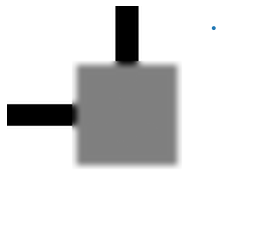

Current iteration: 1; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


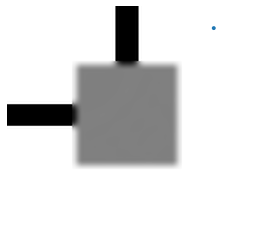

Current iteration: 2; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


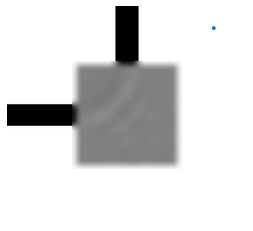

Current iteration: 3; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


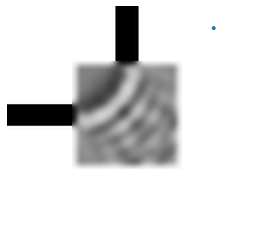

Current iteration: 4; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


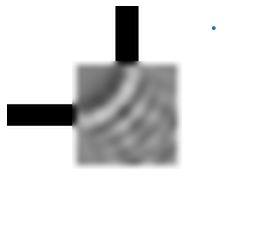

Current iteration: 5; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


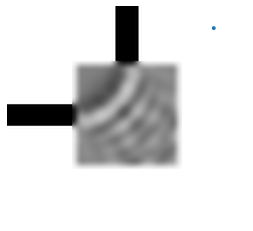

Current iteration: 6; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


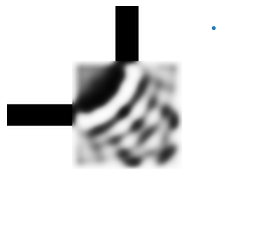

Current iteration: 7; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


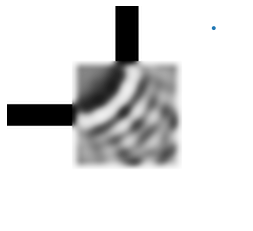

Current iteration: 8; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


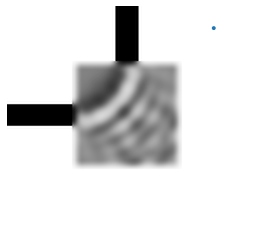

Current iteration: 9; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


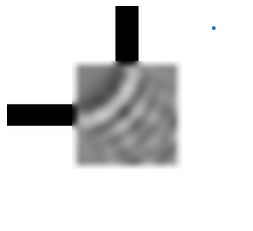

Current iteration: 10; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


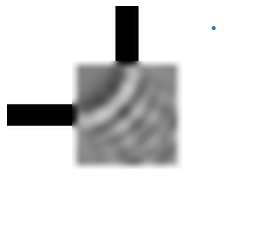

Current iteration: 11; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


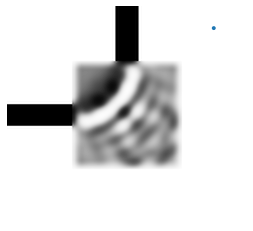

Current iteration: 12; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


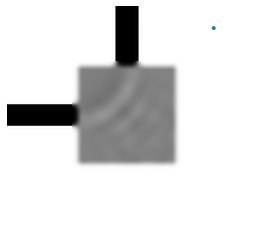

Current iteration: 13; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


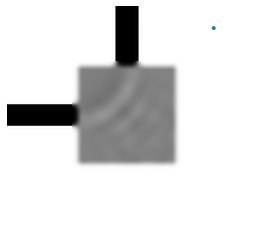

Current iteration: 14; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


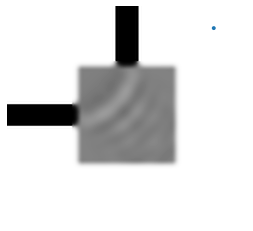

Current iteration: 15; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


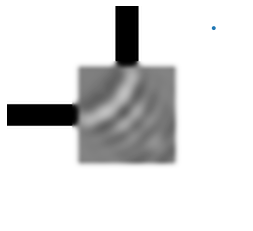

Current iteration: 16; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


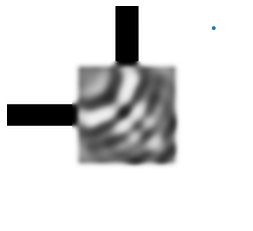

Current iteration: 17; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


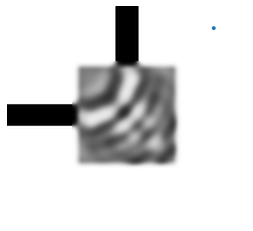

Current iteration: 18; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


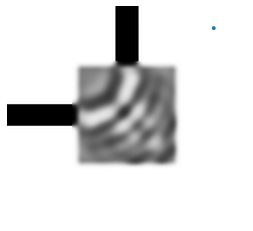

Current iteration: 19; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


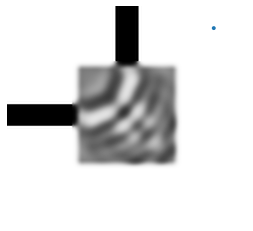

Current iteration: 20; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


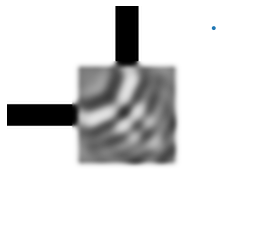

Current iteration: 21; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


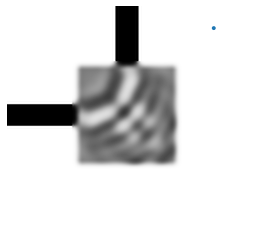

Current iteration: 22; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


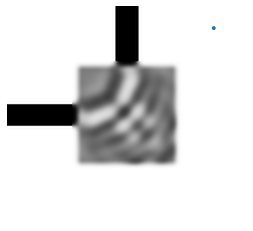

Current iteration: 23; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


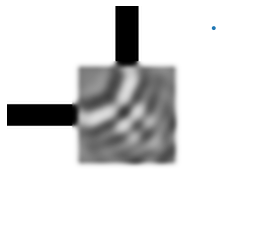

Current iteration: 24; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


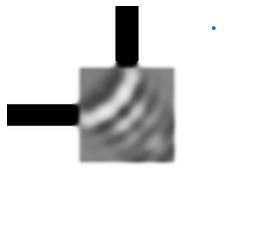

Current iteration: 25; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


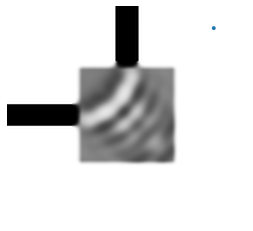

Current iteration: 26; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


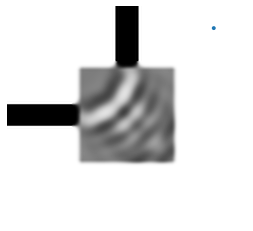

Current iteration: 27; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


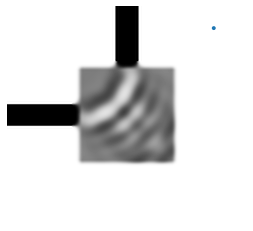

Current iteration: 28; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


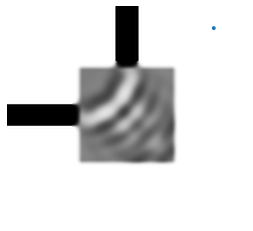

Current iteration: 29; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


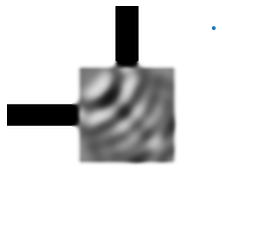

Current iteration: 30; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


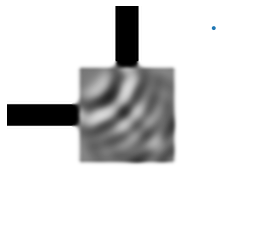

Current iteration: 31; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


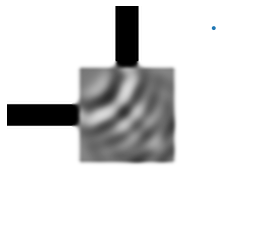

Current iteration: 32; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


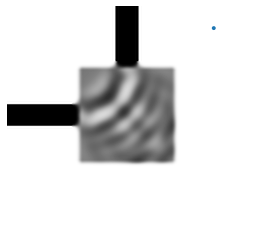

Current iteration: 33; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


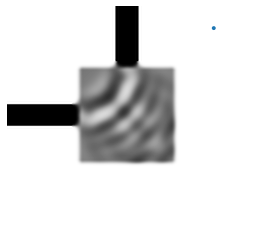

Current iteration: 34; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


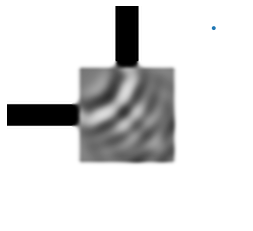

Current iteration: 35; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


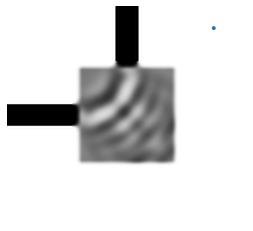

Current iteration: 36; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


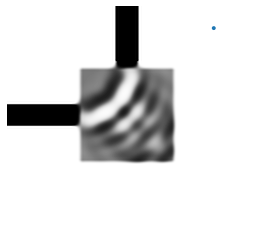

Current iteration: 37; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


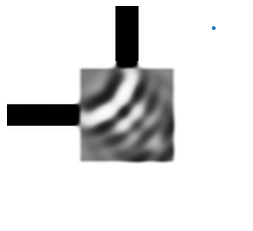

Current iteration: 38; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


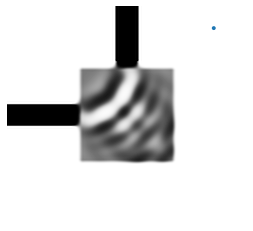

Current iteration: 39; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


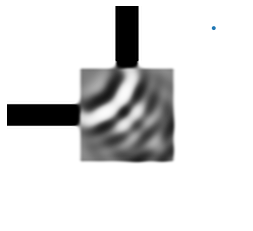

Current iteration: 40; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


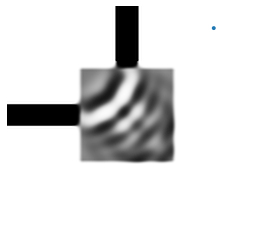

Current iteration: 41; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


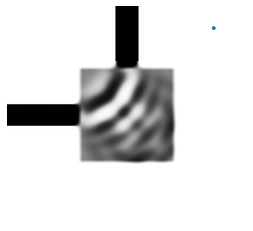

Current iteration: 42; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


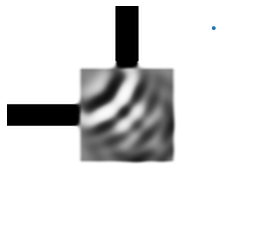

Current iteration: 43; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


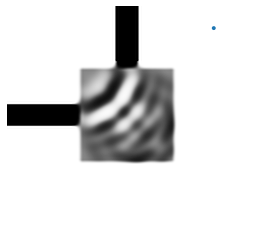

Current iteration: 44; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


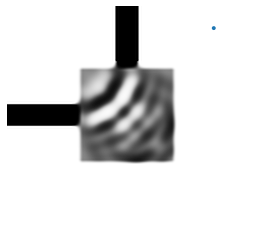

Current iteration: 45; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


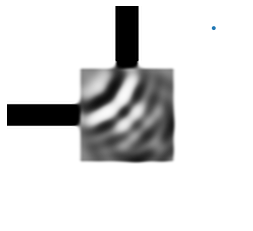

Current iteration: 46; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


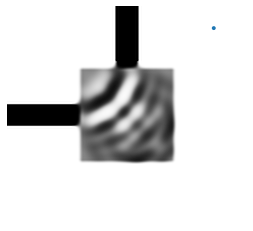

Current iteration: 47; current eta: 0.5, current beta: 32
Starting forward run...
Starting adjoint run...
Calculating gradient...


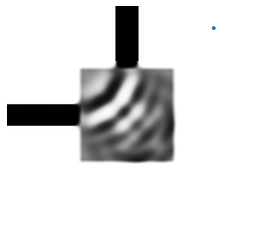

Current iteration: 48; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


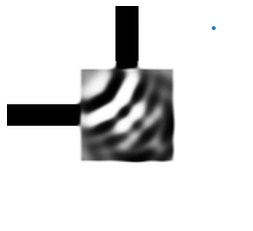

Current iteration: 49; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


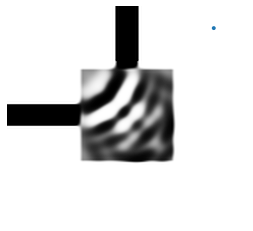

Current iteration: 50; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


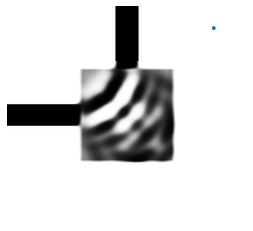

Current iteration: 51; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


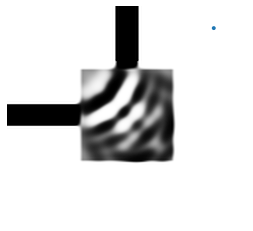

Current iteration: 52; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


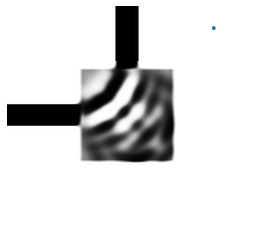

Current iteration: 53; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


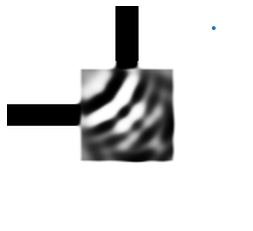

Current iteration: 54; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


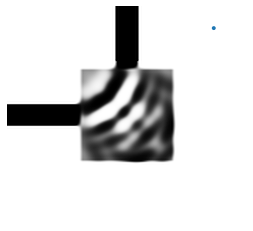

Current iteration: 55; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


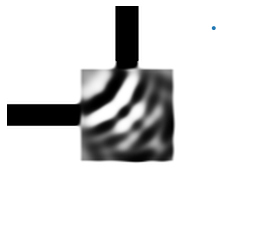

Current iteration: 56; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


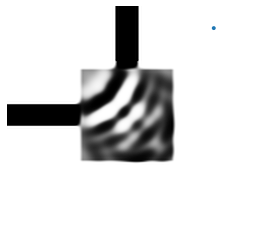

Current iteration: 57; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


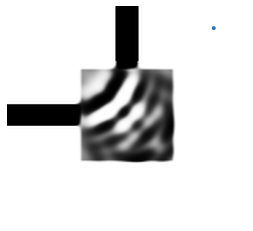

Current iteration: 58; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


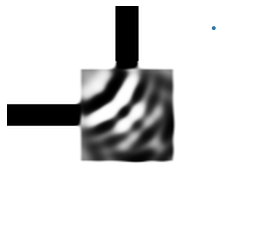

Current iteration: 59; current eta: 0.5, current beta: 64
Starting forward run...
Starting adjoint run...
Calculating gradient...


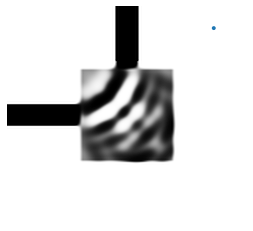

Current iteration: 60; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


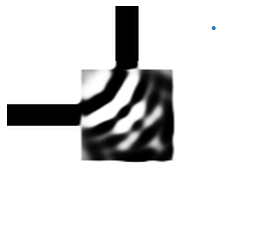

Current iteration: 61; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


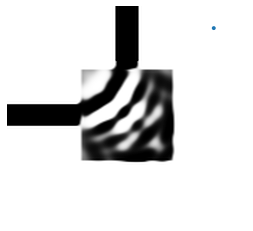

Current iteration: 62; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


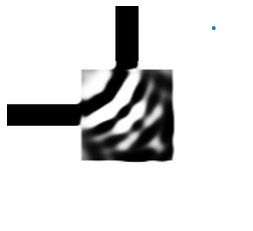

Current iteration: 63; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


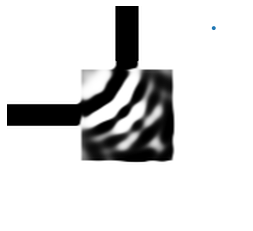

Current iteration: 64; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


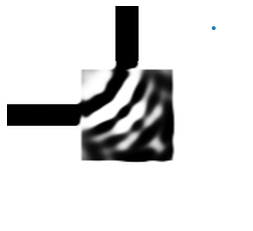

Current iteration: 65; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


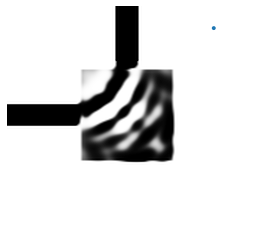

Current iteration: 66; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


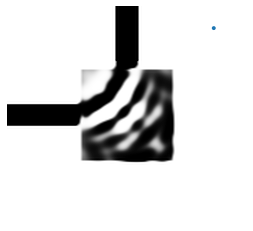

Current iteration: 67; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


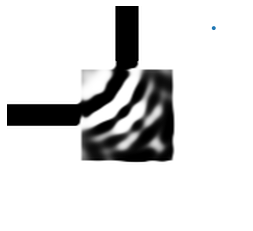

Current iteration: 68; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


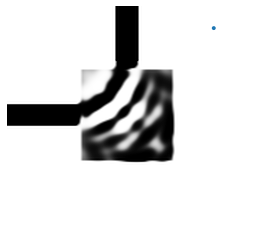

Current iteration: 69; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


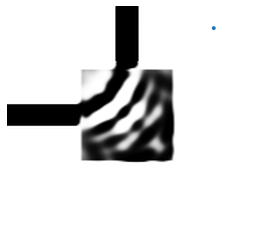

Current iteration: 70; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


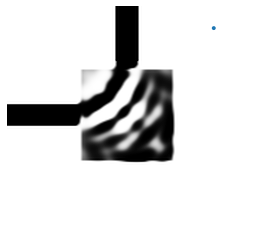

Current iteration: 71; current eta: 0.5, current beta: 128
Starting forward run...
Starting adjoint run...
Calculating gradient...


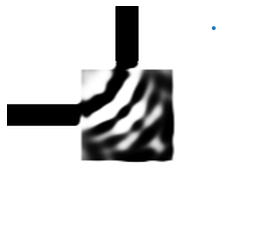

In [7]:
algorithm = nlopt.LD_MMA
n = Nx * Ny # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1 # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0 # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx*Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx*Ny,))
ub[SiO2_mask.flatten()] = 0

# insert dummy parameter bounds and variable
x = np.insert(x,0,0.5) # our initial guess for the worst error
lb = np.insert(lb,0,0) # we can't get less than 0 error!
ub = np.insert(ub,0,1) # we can't get more than 1 error!

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n+1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(update_factor)
    solver.add_inequality_mconstraint(lambda r,x,g: c(r,x,g,eta_i,cur_beta), np.array([1e-3]*nf))
    x[:] = solver.optimize(x)
    cur_beta = cur_beta*beta_scale

Since we are optimizing over the entire frequency band, we can visualize the upper and lower bounds of the device's performance as a function of iteration.

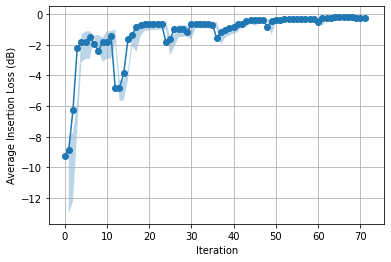

In [8]:
lb = 1-np.min(evaluation_history,axis=1)
ub = 1-np.max(evaluation_history,axis=1)
mean = 1-np.mean(evaluation_history,axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(np.arange(1,num_iters+1),10*np.log10(lb),10*np.log10(ub),alpha=0.3)
plt.plot(10*np.log10(mean),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Average Insertion Loss (dB)')
plt.show()

We can plot our results and see the resulting geometry.

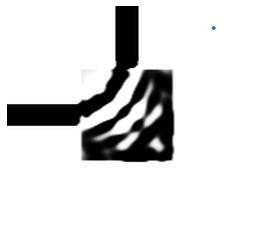

In [9]:
opt.update_design([mapping(x[1:],eta_i,cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(False,ax=ax,plot_sources_flag=False,plot_monitors_flag=False,plot_boundaries_flag=False)
circ = Circle((2,2),minimum_length/2)
ax.add_patch(circ)
ax.axis('off')
plt.show()

As before, we'll check the final frequency response. We see that the response is much "flatter" across the band, and the worst performing frequency is much better than with the MSE approach.

In [10]:
f0, dJ_du = opt([mapping(x[1:],eta_i,cur_beta)],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef = opt.get_objective_arguments()

top_profile = np.abs(top_coef/source_coef) ** 2

Starting forward run...


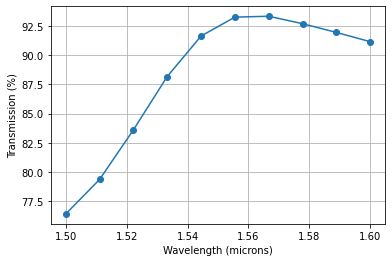

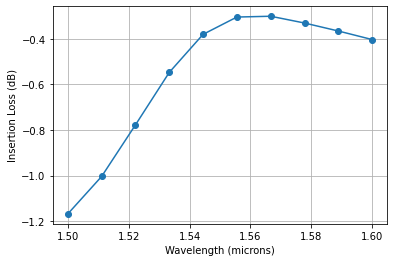

In [13]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transmission (%)')
#plt.ylim(80,100)
plt.show()

plt.figure()
plt.plot(1/frequencies,10*np.log10(top_profile),'-o')
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion Loss (dB)')
#plt.ylim(-0.1,0)
plt.show()

In summary, it is very easy to implement design constraints and density parameter operations using the native adjoint solver interface. One could use this same design flow to implement robus optimization over many frequency points.